# Regrid FESOM to Regular Grid

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd 

import sys
sys.path.append("../")

import pyfesom as pf
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from matplotlib import cm 
from netCDF4 import Dataset

import glob

import cmocean as cmo
import cftime

from IPython import display
from tqdm import tqdm

sys.path.append("/albedo/home/quraus001/FESOM-FS-subduction/functions/")
import FESOM_processing as fprc
import FESOM_plotting as fplt

import xesmf as xe
print(xe.__version__)

/albedo/home/quraus001/pyfesom/pyfesom/climatology.py:21: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


0.8.10


In [3]:
meshpath = "/albedo/home/quraus001/Arc08_sub/"
datapath = "/albedo/work/projects/oce_rio/cwekerle/result/Arc40/from_1988_erai/"
plotpath = "/albedo/home/quraus001/FESOM-FS-subduction/plots/"

In [13]:
mesh   = pf.load_mesh(meshpath)
ds_oce = fprc.load_FESOM_data_with_grid(meshpath, datapath + "Arc40.2002.oce.mean.sub.nc", vars="oce")

file = "/albedo/work/projects/oce_rio/cwekerle/result/Arc22_sub_daily/gridded_python/Arc22.gridded_100m_oce_2006_2009_new.nc"
ds_gridded = xr.open_dataset(file)
ds_gridded = ds_gridded.rename({'longitude': 'lon', 'latitude': 'lat'})

/albedo/home/quraus001/Arc08_sub/pickle_mesh_py3
3
The usepickle == True)
The pickle file for python 3 exists.
The mesh will be loaded from /albedo/home/quraus001/Arc08_sub/pickle_mesh_py3


## Create Land-Sea Mask for New Grid

In [ ]:
# Load Bathymetry data
ds_bath = xr.open_dataset("/albedo/work/user/quraus001/bath/ETOPO_2022_v1_60s_N90W180_bed.nc")

# Crop to Fram Strait region
ds_fram_bath = ds_bath.sel(
    lon=slice(-35, 35),    
    lat=slice(70, 85)).copy()
ds_fram_bath = ds_fram_bath.rename({'lon': 'lon', 'lat': 'lat'})

# Create a new grid
grid_out = xr.Dataset({
    'lon': (['lon'], ds_gridded.lon.values),
    'lat': (['lat'], ds_gridded.lat.values),
})

# Regridder
regridder = xe.Regridder(ds_fram_bath, grid_out, method='bilinear', periodic=False)
z_interp = regridder(ds_fram_bath['z'])
# Create a mask for land points
lsmask = z_interp > 0
# add names to the mask
lsmask = lsmask.rename('lsmask')
lsmask.to_netcdf("FESOM-FS-lsmask_regridded_lat825-lon800.nc")

: 

## Loading LS Mask

In [11]:
ds_lsmask = xr.open_dataset("FESOM-FS-lsmask_regridded_lat825-lon800.nc")
ds_lsmask = ds_lsmask.rename({'__xarray_dataarray_variable__': 'lsmask'})
lsmask = ds_lsmask.lsmask
ds_lsmask

<xarray.Dataset> Size: 673kB
Dimensions:  (lon: 800, lat: 825)
Coordinates:
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
Data variables:
    lsmask   (lat, lon) bool 660kB ...

## Regridding one depth level

In [15]:
depth_level = 0
variables = ["u", "v", "temp", "salt"]

# Grid
lon_new = np.linspace(ds_gridded.lon.min().item(), ds_gridded.lon.max().item(), len(ds_gridded.lon))
lat_new = np.linspace(ds_gridded.lat.min().item(), ds_gridded.lat.max().item(), len(ds_gridded.lat))
lon_mesh, lat_mesh = np.meshgrid(lon_new, lat_new)

# Create dataset for gridded data
ds_gridded = xr.Dataset(
    {
        "temp": (["time", "lat", "lon"], np.zeros((len(ds_oce.time), len(lat_new), len(lon_new)))),
        "salt": (["time", "lat", "lon"], np.zeros((len(ds_oce.time), len(lat_new), len(lon_new)))),
        "u": (["time", "lat", "lon"], np.zeros((len(ds_oce.time), len(lat_new), len(lon_new)))),
        "v": (["time", "lat", "lon"], np.zeros((len(ds_oce.time), len(lat_new), len(lon_new)))),
    },
    coords={
        "time": ds_oce.time.values,
        "lat": (["lat"], lat_new),
        "lon": (["lon"], lon_new),
    },
)

for variable in variables:
    print(variable)
    for idx, time in tqdm(enumerate(ds_oce.time.values[:])):
        # Get the data for the current time step
        raw_data     = fprc.reshape_3d_nodes(ds_oce, variable, time_idx=idx)
        # Interpolate the data to the new grid
        gridded_data = pf.fesom2regular(raw_data[:,depth_level], mesh, lon_mesh, lat_mesh , how='nn')
        # Apply the mask to the gridded data
        gridded_data[lsmask] = np.nan  # Set land points to NaN
        # Store the gridded data in the dataset
        ds_gridded[variable].loc[dict(time=time)] = gridded_data

# Save the gridded dataset to a NetCDF file
output_file = "/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_new.nc"
ds_gridded.to_netcdf(output_file, mode='w', format='NETCDF4')
ds_gridded

u


365it [24:18,  4.00s/it]


v


365it [23:59,  3.94s/it]


temp


365it [23:53,  3.93s/it]


salt


365it [23:50,  3.92s/it]


<xarray.Dataset> Size: 8GB
Dimensions:  (time: 365, lat: 825, lon: 800)
Coordinates:
  * time     (time) object 3kB 2002-01-01 23:57:30 ... 2002-12-31 23:57:30
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
Data variables:
    temp     (time, lat, lon) float64 2GB nan -1.731 -1.731 ... -1.841 -1.841
    salt     (time, lat, lon) float64 2GB nan 31.71 31.71 ... 33.61 33.6 33.6
    u        (time, lat, lon) float64 2GB nan 0.01576 ... 0.01552 0.01552
    v        (time, lat, lon) float64 2GB nan 0.00879 ... -0.00428 -0.00428

## Regridding 3D

In [ ]:
depth_level = 0
variables = ["u", "v", "temp"]#, "salt"]
times = ds_oce.time.values[:30]

# Grid
lon_new = np.linspace(ds_gridded.lon.min().item(), ds_gridded.lon.max().item(), len(ds_gridded.lon))
lat_new = np.linspace(ds_gridded.lat.min().item(), ds_gridded.lat.max().item(), len(ds_gridded.lat))
lon_mesh, lat_mesh = np.meshgrid(lon_new, lat_new)

# Create dataset for gridded data
ds_gridded = xr.Dataset(
    {
        "temp": (["time", "lat", "lon"], np.zeros((len(times), len(lat_new), len(lon_new)))),
        "salt": (["time", "lat", "lon"], np.zeros((len(times), len(lat_new), len(lon_new)))),
        "u": (["time", "lat", "lon"], np.zeros((len(times), len(lat_new), len(lon_new)))),
        "v": (["time", "lat", "lon"], np.zeros((len(times), len(lat_new), len(lon_new)))),
    },
    coords={
        "time": times,
        "lat": (["lat"], lat_new),
        "lon": (["lon"], lon_new),
    },
)

for variable in variables:
    print(variable)
    for idx, time in tqdm(enumerate(times)):
        # Get the data for the current time step
        raw_data = fprc.reshape_3d_nodes(ds_oce, variable, time_idx=idx)

        for depth_level in range(raw_data.shape[1]):
            # Interpolate the data to the new grid
            gridded_data = pf.fesom2regular(raw_data[:,depth_level], mesh, lon_mesh, lat_mesh , how='nn')
            # Apply the mask to the gridded data
            gridded_data[lsmask] = np.nan  # Set land points to NaN
            # Store the gridded data in the dataset
            ds_gridded[variable].loc[dict(time=time)] = gridded_data

# Save the gridded dataset to a NetCDF file
output_file = "/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_3d.nc"
ds_gridded.to_netcdf(output_file, mode='w', format='NETCDF4')
ds_gridded

u


30it [59:18, 118.62s/it]


v


3it [05:48, 115.88s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ffff450ea70>>
Traceback (most recent call last):
  File "/albedo/home/quraus001/miniforge3/envs/pyfesom_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
  File "/albedo/home/quraus001/miniforge3/envs/pyfesom_env/lib/python3.10/threading.py", line 1486, in enumerate
    with _active_limbo_lock:
KeyboardInterrupt: 


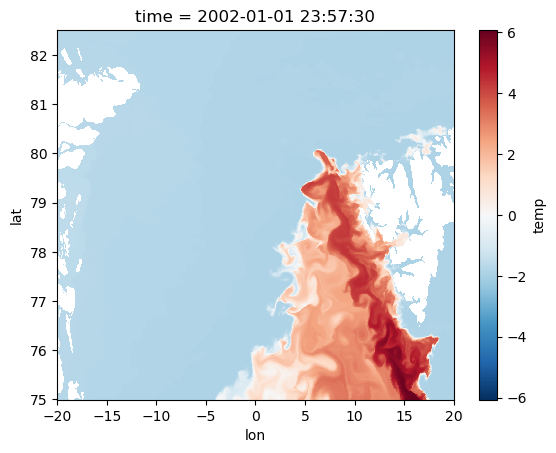

In [22]:
ds_gridded.temp.isel(time=0).plot()